# Transformation of x,y animal position into a grid cell network coordinate system

Grid cells can be modelled by 3 oscillatory patterns set at 60 degrees of eachother.

We can thus imagine that the grid cell network could represent the position in the grid pattern using 3 angles. We will call this space the grid cell coordinates.

We need functions to go from cartesian coordinate to grid cell coordinate and from grid cell coordinates to cartesian.

When we go from grid cells coordinates to cartesian, we don't know the position of the mouse because of the repetitive nature of the grid pattern. But we can recreate a path and we can get the direction of movement.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np

from functions import *

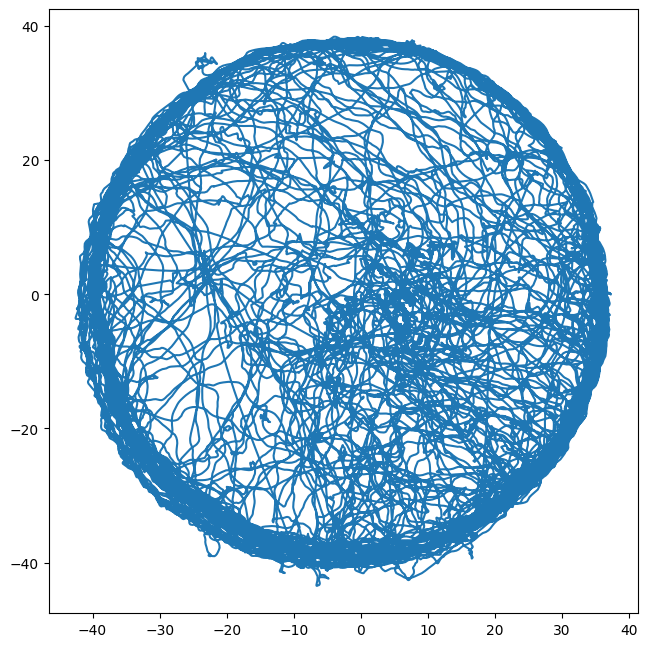

In [3]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=lastRF)


fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal')  

# Mapping position data to the toroidal manifold

The position code of grid cell is periodic, with 60-degree organization.

For instance we can generate a grid pattern using 3 oscillatory patterns oriented at 0, 60 and 120 degrees.

In [4]:
# get matrices covering position -40 to 40 in 2D
nData = 80
x, y = np.meshgrid(np.linspace(-40,40,nData),np.linspace(-40,40,nData))
poseSim = np.stack([x.flatten(),y.flatten()]).T
x.shape, poseSim.shape, x.min(),x.max()

((80, 80), (6400, 2), -40.0, 40.0)

In [5]:
fn = os.path.join("../data","grid_cell_parameters.pkl")
grid_param = pickle.load(open(fn,"rb"))

oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in grid_param])
oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in grid_param])
periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in grid_param])
periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in grid_param])


grid_param = {
"period": np.median(periodFlexible,axis=0),
"orientation": np.median(oriFlexible,axis=0),
}

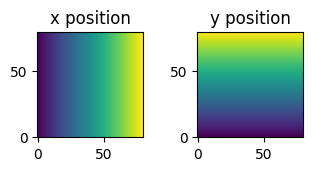

In [6]:
rowSize,colSize= 1.6,1.6
ncols=2
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(mainSpec[0])
ax.imshow(x,origin="lower")
ax.set_title("x position")
ax = fig.add_subplot(mainSpec[1])
ax.imshow(y,origin="lower")
ax.set_title("y position")
plt.show()

In [7]:
# get how far an animal has run along 3 different axes
# these are like rotation matrices, but we only want the x component
# to get the x component of a rotated vector, just multiply with [cos(delta),-sin(delta)]
ori = grid_param["orientation"][0]
deltas = grid_param["orientation"]

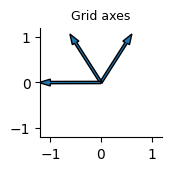

In [8]:
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
ax = fig.add_subplot(mainSpec[0])
xv,yv = np.cos(deltas),np.sin(deltas)
for i in range(deltas.shape[0]):
    ax.arrow(x=0,y=0, dx=xv[i],dy=yv[i],width = 0.05)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.set_title("Grid axes",fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

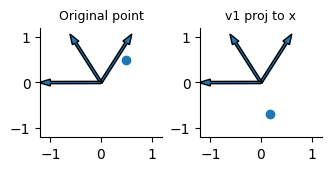

In [9]:
ncols=2
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


ax = fig.add_subplot(mainSpec[0])
xv,yv = np.cos(deltas),np.sin(deltas)
for i in range(deltas.shape[0]):
    ax.arrow(x=0,y=0, dx=xv[i],dy=yv[i],width = 0.05)
aPoint = np.array([[0.5,0.5]])
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.scatter(aPoint[0,0],aPoint[0,1])
ax.set_title("Original point",fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(mainSpec[1])

# rotation matrix
A = np.array([[np.cos(-deltas[1]), -np.sin(-deltas[1])], [np.sin(-deltas[1]), np.cos(-deltas[1])]])


rotPoint = A@aPoint.T
xv,yv = np.cos(deltas),np.sin(deltas)
for i in range(deltas.shape[0]):
    ax.arrow(x=0,y=0, dx=xv[i],dy=yv[i],width = 0.05)
aPoint = np.array([0.5,0.5])
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.scatter(rotPoint[0],rotPoint[1])
ax.set_title("v1 proj to x",fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

After the rotation, the x component of the point is the same as its projection onto v1.

Since all we care is the x component of the rotated point, we can simplify the rotation matrix to a 2x1 shape.

In [10]:
Rx0 = np.array([[np.cos(-deltas[0])],[-np.sin(-deltas[0])]])
Rx1 = np.array([[np.cos(-deltas[1])],[-np.sin(-deltas[1])]])
Rx2 = np.array([[np.cos(-deltas[2])],[-np.sin(-deltas[2])]])
Rx0.shape

(2, 1)

We can do a matrix multiplication 10000,2 * 2, 1 to get a 10000,1 matrix.

In [11]:
d0 = poseSim @ Rx0
d1 = poseSim @ Rx1
d2 = poseSim @ Rx2
d0.shape

(6400, 1)

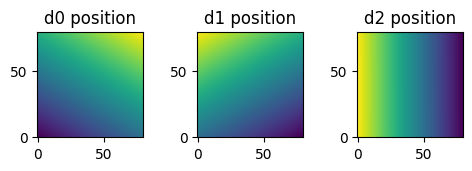

In [12]:
ncols=3
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=1)
ax = fig.add_subplot(mainSpec[0])
ax.imshow(d0.reshape(x.shape),origin="lower")
ax.set_title("d0 position")

ax = fig.add_subplot(mainSpec[1])
ax.imshow(d1.reshape(x.shape),origin="lower")
ax.set_title("d1 position")

ax = fig.add_subplot(mainSpec[2])
ax.imshow(d2.reshape(x.shape),origin="lower")
ax.set_title("d2 position")
plt.show()



c0,c1,c2 is the position of the animal along 3 axes at 60 degrees of each other.

We can use a cos function to turn the linear increase into an oscillatory signal.

Setting the spacing of the grid pattern.

cos(30) = adjacent/hypothenuse

where the hypothenuse is the grid spacing. We want to know the adjacent side.

cos(30)*hypothenuse = adjacent


In [13]:
grid_spacing = grid_param["period"]/np.cos(np.pi/6)

In [14]:
pattern_spacing = grid_param["period"][0]

In [15]:
phases = np.array([2*np.pi/2,0,2*np.pi/4*3])

In [16]:
c0 = np.cos(d0*np.pi*2 / pattern_spacing + phases[0]) # period is the pattern_spacing
c1 = np.cos(d1*np.pi*2 / pattern_spacing + phases[1]) 
c2 = np.cos(d2*np.pi*2 / pattern_spacing + phases[2])

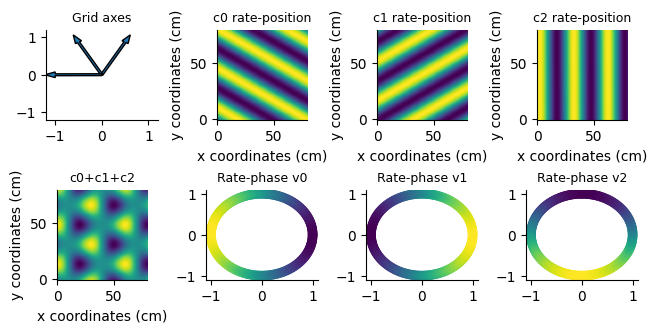

In [17]:
ncols=4
nrows=2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


ax = fig.add_subplot(mainSpec[0,0])
xv,yv = np.cos(deltas),np.sin(deltas)
for i in range(deltas.shape[0]):
    ax.arrow(x=0,y=0, dx=xv[i],dy=yv[i],width = 0.05)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
ax.set_title("Grid axes",fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(mainSpec[0,1])
ax.imshow(c0.reshape(x.shape),origin="lower")
ax.set_title("c0 rate-position",fontsize=9)
ax.set_xlabel("x coordinates (cm)")
ax.set_ylabel("y coordinates (cm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(mainSpec[0,2])
ax.imshow(c1.reshape(x.shape),origin="lower")
ax.set_title("c1 rate-position",fontsize=9)
ax.set_xlabel("x coordinates (cm)")
ax.set_ylabel("y coordinates (cm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(mainSpec[0,3])
ax.imshow(c2.reshape(x.shape),origin="lower")
ax.set_title("c2 rate-position",fontsize=9)
ax.set_xlabel("x coordinates (cm)")
ax.set_ylabel("y coordinates (cm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(mainSpec[1,0])
ax.imshow((c0+c1+c2).reshape(x.shape),origin="lower")
ax.set_title("c0+c1+c2",fontsize=9)
ax.set_xlabel("x coordinates (cm)")
ax.set_ylabel("y coordinates (cm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = fig.add_subplot(mainSpec[1,1])
angles = np.linspace(-np.pi,np.pi,200)
colors = np.cos(angles)+1/2
xx = np.cos(angles+phases[0])
yy = np.sin(angles+phases[0])
ax.scatter(xx,yy,c=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Rate-phase v0",fontsize=9)


ax = fig.add_subplot(mainSpec[1,2])
angles = np.linspace(-np.pi,np.pi,200)
colors = np.cos(angles)+1/2
xx = np.cos(angles+phases[1])
yy = np.sin(angles+phases[1])
ax.scatter(xx,yy,c=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Rate-phase v1",fontsize=9)

ax = fig.add_subplot(mainSpec[1,3])
angles = np.linspace(-np.pi,np.pi,200)
colors = np.cos(angles)+1/2
xx = np.cos(angles+phases[2])
yy = np.sin(angles+phases[2])
ax.scatter(xx,yy,c=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Rate-phase v2",fontsize=9)

plt.show()


You can view the 3 components as being the basis for the grid cell pattern.

We can represent the activity bump in the grid manifold with 3 angles. We can set the values from -np.pi to np.pi as the range of the angle. To avoid discontinuity we represent the angle as a circle with the sin and cos component of the angle.

Instead of using the cos function to get the rate, we can get how far we have moved along an axis. We then use arctan2 to get an angle from -pi to pi.

In [18]:
def length_to_angle(x,period):
    xr = x/period*np.pi*2
    return (np.arctan2(np.sin(xr), np.cos(xr)))

# Class for cartesian to toroidal transformation

We want to develop a class that will include all the code to go from x,y to grid representation and back.

We want to visualize the transformation to make sure the transformation is working.

In [19]:
class gridTransformation:
    """
    Class to do deal with the change in coordinate systems when working with grid cell.
    The two main coordinate systems are 1) x,y position of the animal and 2) a 3D representation of position along the 3 axis of the grid pattern v0,v1,v2
    
    Arguments:
    period: length in cm of the underlying oscillation creating the grid pattern. 
    orientation: orientation of the 3 axes of the grid cells in radians.
    """
    
    def __init__(self, period=np.array([40,40,40]),
                       orientation=np.array([0,np.pi/3,np.pi/3*2])):
        self.set_grid_parameters(period,orientation)
        
        
    def set_grid_parameters(self,period,orientation):
        """
        Function to call if you want to modify the parameters of the grid pattern.
        """
        if period.shape[0] != 3:
            raise ValueError("period should have a length of 3")
        if orientation.shape[0] != 3:
            raise ValueError("orientation should have a length of 3")

        self.period = period
        self.orientation = orientation
        self.set_rotation_matrices()
        
        
    def set_rotation_matrices(self):
        # these matrices are used to project the position of the animal in x,y coordinate system on a grid axis
        # Imagine that a position (x,y) for the mouse is a vector. We rotate the vector by the orientation of the grid axis. We can get the x component of that rotated vector.
        self.Rx0 = np.array([[np.cos(-self.orientation[0])],[-np.sin(-self.orientation[0])]]) # minus sign because we want to rotate the inverse of the angle to bring it back to 1,0 
        self.Rx1 = np.array([[np.cos(-self.orientation[1])],[-np.sin(-self.orientation[1])]])
        self.Rx2 = np.array([[np.cos(-self.orientation[2])],[-np.sin(-self.orientation[2])]])
        
       
    def __str__(self):
        return f'Grid period: {self.period}, Grid orientation: {self.orientation}\nRx0: {self.Rx0}\nRx1: {self.Rx1}\nRx2: {self.Rx2}' 
        
    def __rep__(self):
        return f'Grid period: {self.period}, Grid orientation: {self.orientation}'
   
    def poseToGridSpace(self, pose, angularCoordinate = True, returnCosSin = True):
        """
        Function to transfrom the x,y position of the mouse to 
        a position within the internal representation of grid cells.
        
        The internal representation can be set to be circular (default) or linear
        
        Argument:
        pose: x,y position of the mouse. np.array with 2 columns
        angularCoordinate: whether to transform the position along the grid axes to circular data
        returnCosSin: if angularCoordinate is True, whether to return the cos and sin of the 3 grid angles or return the angle itself.
        """
        
        if pose.shape[1] != 2:
            raise ValueError("pose should have 2 columns")
        
        d0 = pose @ self.Rx0 # d for distance along an axis
        d1 = pose @ self.Rx1
        d2 = pose @ self.Rx2

        if angularCoordinate:
            
            # this turn the disance along each axes as an angle that range from a distance of 0 to the period of the grid pattern.
            c0 = self.length_to_angle(d0, self.period[0]) # c because it is now circular
            c1 = self.length_to_angle(d1, self.period[1]) 
            c2 = self.length_to_angle(d2, self.period[2])
        

            if returnCosSin:
                # we get the cos and sin of each angle as it is easier to work with when training models.
                c0c = np.cos(c0)
                c0s = np.sin(c0)
                c1c = np.cos(c1)
                c1s = np.sin(c1)
                c2c = np.cos(c2)
                c2s = np.sin(c2)
                # return the cos and sin of our 3 angles
                return np.stack([c0c.flatten(),
                                 c0s.flatten(),
                                 c1c.flatten(),
                                 c1s.flatten(),
                                 c2c.flatten(),
                                 c2s.flatten()]).T
            else: # return the angle in radians
                return np.squeeze(np.stack([c0,c1,c2])).T
        else:
            # we want linear data normalize by the period
            
            return np.squeeze(np.stack([d0/self.period[0],
                                        d1/self.period[1],
                                        d2/self.period[2]])).T
        
        
    def length_to_angle(self,x,period):
        """
        Function to turn a distance along a grid axis to an angle. 
        A distance of 1 period with be equal to 2*pi. 
        If the animal goes further along the axis, it is like going back to 0, i.e., this is a circular axis.
        
        We use np.arctan2(np.sin, np.cos) instead of a modulo because a modulo function is not differentialble.
        """
        xr = x/period*np.pi*2
        return (np.arctan2(np.sin(xr), np.cos(xr)))

In [20]:
ap.pose.shape

(90000, 8)

In [21]:
gt = gridTransformation(period = grid_param['period'],
                       orientation = grid_param['orientation'])
print(gt)
p = ap.pose[5500:6000,1:3].copy()

grid_coord = gt.poseToGridSpace(p,angularCoordinate = True, returnCosSin=False)

Grid period: [30.339401 30.350828 30.323168], Grid orientation: [1.0485003 2.0950065 3.1434677]
Rx0: [[0.49887136]
 [0.86667603]]
Rx1: [[-0.50052935]
 [ 0.86571956]]
Rx2: [[-0.9999983 ]
 [-0.00187501]]


In [22]:
p

array([[-2.31955401e+01, -3.64170114e+01],
       [-2.31682370e+01, -3.66505704e+01],
       [-2.31988414e+01, -3.69191901e+01],
       [-2.31430319e+01, -3.72719514e+01],
       [-2.30163958e+01, -3.76781602e+01],
       [-2.29447586e+01, -3.79738708e+01],
       [-2.28908279e+01, -3.82020430e+01],
       [-2.28303283e+01, -3.83484315e+01],
       [-2.27397208e+01, -3.84949227e+01],
       [-2.26025083e+01, -3.86306737e+01],
       [-2.25466150e+01, -3.87173544e+01],
       [-2.25184490e+01, -3.87734776e+01],
       [-2.24841761e+01, -3.87905201e+01],
       [-2.24341899e+01, -3.88055252e+01],
       [-2.23927088e+01, -3.88200802e+01],
       [-2.24592666e+01, -3.88415203e+01],
       [-2.25532027e+01, -3.88576867e+01],
       [-2.26334453e+01, -3.88550537e+01],
       [-2.26928790e+01, -3.88736779e+01],
       [-2.27088281e+01, -3.89259748e+01],
       [-2.26735209e+01, -3.89804325e+01],
       [-2.26163745e+01, -3.90138742e+01],
       [-2.25639092e+01, -3.89944451e+01],
       [-2.

In [23]:
grid_coord = grid_coord[:,:2]

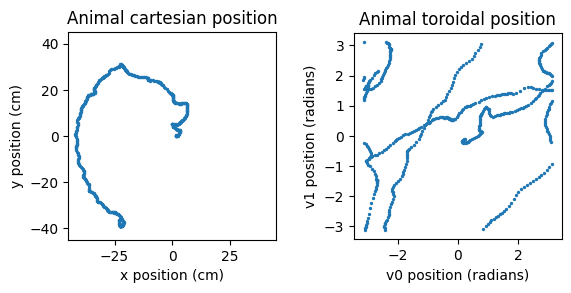

In [24]:
colSize = 2.8
rowSize = 2.8
ncols=2
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
plt.rcParams['figure.dpi'] = 300

mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows,wspace=0.1)
ax = fig.add_subplot(mainSpec[0])
ax.scatter(p[:,0],p[:,1],s=2)
ax.set_aspect('equal')  

ax.set_xlim(-45,45)
ax.set_ylim(-45,45)

ax.set_xlabel("x position (cm)")
ax.set_ylabel("y position (cm)")

ax.set_title('Animal cartesian position')

ax = fig.add_subplot(mainSpec[1])
ax.scatter(grid_coord[:,0],grid_coord[:,1],s=2)
ax.set_aspect('equal')  

ax.set_xlabel("v0 position (radians)")
ax.set_ylabel("v1 position (radians)")

ax.set_title('Animal toroidal position')

fig.savefig('../img/notebook3_animal_cartesian_vs_toroidal.png',dpi=300,bbox_inches='tight')

In [25]:
# Install imageio if you want to make a gif that shows this:

In [26]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Parameters for the animation
colSize = 2.8
rowSize = 2.8
ncols = 2
nrows = 1
frames = 5  # Total number of frames in the animation

# Create a list to store each frame
filenames = []

blocks = p.shape[0]/frames

for i in range(int(blocks)):
    fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True)
    plt.rcParams['figure.dpi'] = 300

    mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows, wspace=0.1)
    
    # Cartesian position
    ax = fig.add_subplot(mainSpec[0])
    ax.scatter(p[:i*frames,0], p[:i*frames,1], s=2)
    ax.set_aspect('equal')
    ax.set_xlim(-45, 45)
    ax.set_ylim(-45, 45)
    ax.set_xlabel("x position (cm)")
    ax.set_ylabel("y position (cm)")
    ax.set_title('Animal cartesian position')
    
    # Toroidal position
    ax = fig.add_subplot(mainSpec[1])
    ax.scatter(grid_coord[:i*frames,0], grid_coord[:i*frames,1], s=2)
    ax.set_aspect('equal')
    ax.set_xlabel("v0 position (radians)")
    ax.set_ylabel("v1 position (radians)")
    ax.set_title('Animal toroidal position')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    
    # Save the current frame
    filename = f'frame_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Create the GIF
with imageio.get_writer('../img/notebook3_animal_positions.gif', mode='I', fps=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove the frames
import os
for filename in filenames:
    os.remove(filename)


/tmp/ipykernel_5667/2512136932.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Parameters for the animation
colSize = 2.8
rowSize = 2.8
ncols = 1
nrows = 1
frames = 5  # Total number of frames in the animation

# Create a list to store each frame
filenames = []

blocks = p.shape[0]/frames

for i in range(int(blocks)):
    fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True)
    plt.rcParams['figure.dpi'] = 300

    mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows, wspace=0.1)
    
    # Cartesian position
    # ax = fig.add_subplot(mainSpec[0])
    # ax.scatter(p[:i*frames,0], p[:i*frames,1], s=2)
    # ax.set_aspect('equal')
    # ax.set_xlim(-45, 45)
    # ax.set_ylim(-45, 45)
    # ax.set_xlabel("x position (cm)")
    # ax.set_ylabel("y position (cm)")
    # ax.set_title('Animal cartesian position')
    
    # Toroidal position
    ax = fig.add_subplot(mainSpec[0])
    ax.scatter(grid_coord[:i*frames,0], grid_coord[:i*frames,1], s=2)
    ax.set_aspect('equal')
    ax.set_xlabel("v0 position (radians)")
    ax.set_ylabel("v1 position (radians)")
    ax.set_title('Animal toroidal position')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    
    # Save the current frame
    filename = f'frame_{i}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Create the GIF
with imageio.get_writer('../img/notebook3_animal_positions_only_toroidal.gif', mode='I', fps=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove the frames
import os
for filename in filenames:
    os.remove(filename)

/tmp/ipykernel_5667/1850567925.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
